# Generative Models (160 + 40 points)

## Diffusion Models vs. GANs vs. VAE

### HW4 @ DL Course, Dr. Soleymani, Spring 2023

*Full Name:* ...

*SID:* ...

In this notebook, we are going to implement Variational AutoEncoder (VAE), Denoising Diffusion Probabilistic Model (DDPM) and Generative Adversarial Network (GAN) on the FashionMNIST dataset. To generate images, these models convert noise to images from the training distribution, but the key difference is that Diffusion models denoise the image gradually. The following sections briefly describe each model.

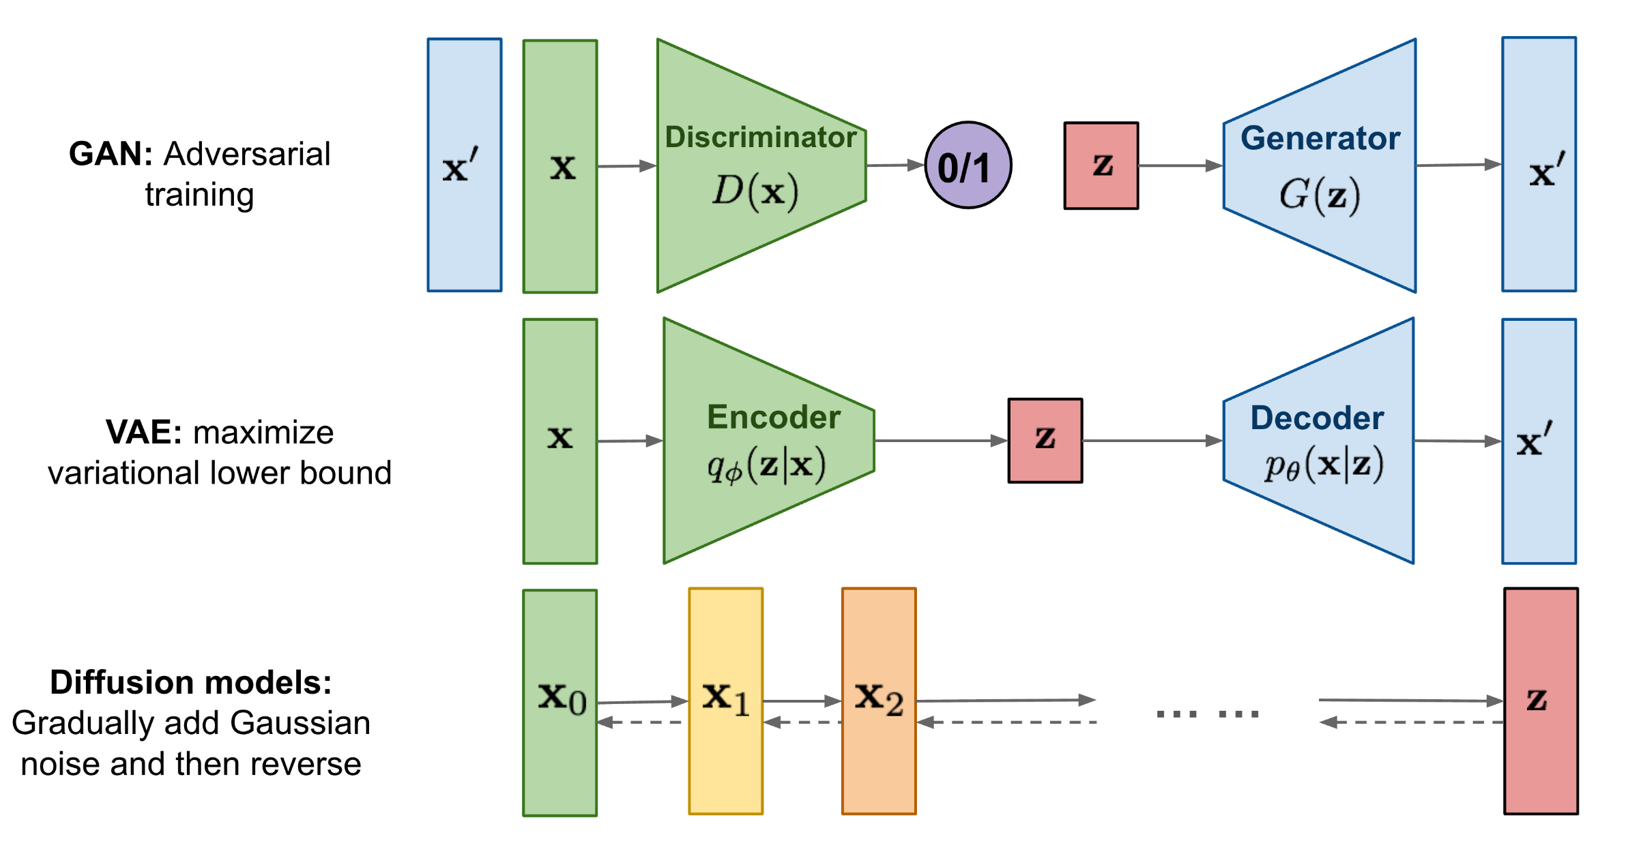

**NOTICE:** 
+ Please complete the code in the given structure. You may change the hyperparameters according to your computing power as long as the results indicate the desired performance.
+ Complete the `TODO` parts in the code accordingly. 
+ Remember to answer the conceptual questions. 

## Dataset

We are going to work on the FashionMNIST dataset. FashionMNIST consists of a training set of 60,000 examples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image associated with a label from 10 classes. We are going to use the training split in this notebook. You can use `dataloader` to train your models. Also, you can use `plot_samples` to plot a sequence of images (e.g. iteratively denoised images by DDPM).

In [ ]:
from torchvision import transforms 
from torch.utils.data import DataLoader
from torch import optim
from tqdm.notebook import tqdm
from torch.autograd import Variable 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

BATCH_SIZE = 8
IMG_SIZE = 32 
C_IN = 1 # Number of input channels
LR = 2e-5
EPOCHS = 500

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

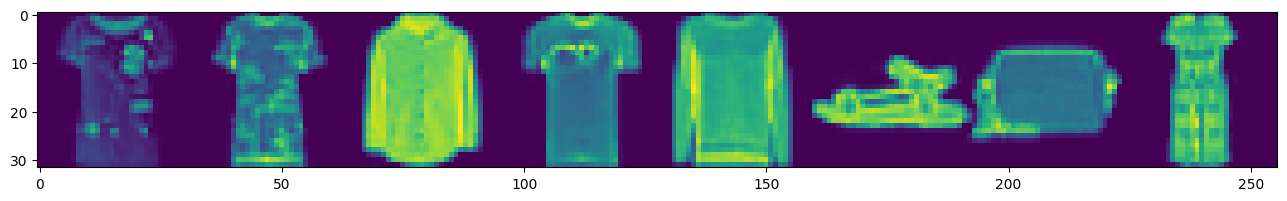

In [ ]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  
        transforms.Lambda(lambda t: (t * 2) - 1) 
    ]

    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.FashionMNIST(root=".", download=True, 
                                         train=True, transform=data_transform)
    return data


def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, 
                        shuffle=True, drop_last=True)
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

## VAE (38 points)

VAE is a generative model consisting of an encoder network and a decoder network. The encoder maps the input data into a latent space, where the data is represented by probability distributions. A decoder network generates the output data from samples of the latent space.

VAE is trained using a variational inference approach, where the goal is to maximize the evidence lower bound (ELBO) of the log-likelihood of the data. The ELBO consists of two terms: the reconstruction loss, which measures how well the decoder can reconstruct the input data from the latent space, and the KL divergence between the prior (considered Gaussian) and posterior distributions over the latent space. The posterior distribution is usually considered Gaussian, and the encoder only tries to learn its mean and variance. Given the mean and the variance, one can use the reparameterization trick to sample from the encoder.

### ❓ **Question 1**
*(8 points)*
+ What is the reparameterization trick? How does it affect the sampling and the gradient backpropagation processes?
+ What are the advantages of VAEs over regular Autoencoders?

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(VariationalEncoder, self).__init__()

        ##########################################################
        # TODO (4 points): 
        # Define your variational encoder layers. You may use 
        # linear layers, normalization layers, and activation layers. 
        ##########################################################
        

    def forward(self, x):

        z = None
 
        ##########################################################
        # TODO (8 points): 
        # Convert `x` to the latent `z`. You should first calculate 
        # the mean and the variance for the current input `x` 
        # and then, sample a standard Gaussian noise. Finally convert 
        # the noise to `z` using the mean and the variance.
        ##########################################################

        return z

class Decoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Decoder, self).__init__()        
        
        ##########################################################
        # TODO (2 points): 
        # Define your decoder layers. You may use linear layers, 
        # normalization layers, and activation layers. 
        ##########################################################

    def forward(self, z):

        img = None

        ##########################################################
        # TODO (2 points): 
        # Decode the latent vector `z` to images.
        ##########################################################
        
        return img

class VariationalAutoEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super(VariationalAutoEncoder, self).__init__()

        ##########################################################
        # TODO (2 points): 
        # Instantiate the encoder and the decoder.
        ##########################################################

        self.encoder = None
        self.decoder = None

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class VAEManager():
    def __init__(self, latent_dims):

        ##########################################################
        # TODO (1 points): 
        # Define the VAE and the optimizer. You can use Adam.
        ##########################################################

        self.vae = None

    def train(self, dataloader, **kwargs):

        history = dict(loss=[])
        for epoch in range(EPOCHS):
            total_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE) 

                ##########################################################
                # TODO (8 points): 
                # Calculate the loss.
                # Then, perform the optimization on `batch_x`.
                ##########################################################

                loss = None

                total_loss.append(loss.item())

            mean_loss = np.mean(total_loss)

            print(
                "[Epoch: %d/%d] [loss: %.4f]"
                % (epoch+1, EPOCHS, mean_loss)
            )

            self.sample(8, plot=True)

            history['loss'].append(mean_loss)

        return history

    def sample(self, n, plot=True):

        ##########################################################
        # TODO (3 points): 
        # Interpolate between two randomly chosen points in the latent space,
        # and choose `n` equally-distant latent points between the random points.
        # You should save an array of random latent points in `zs`.
        ##########################################################

        zs = None

        with torch.no_grad():
            images = torch.cat([self.vae.decoder(z) for z in zs], dim=0).detach()
            if plot:
                plot_images(images)
            return images

In [ ]:
vae = VAEManager() # You can pass your arguments to the call.
vae_history = vae.train(dataloader)

## GAN (39 + 15 points)

GAN's architecture consists of a Discriminator and a Generator. The Discriminator identifies whether an input image ($x$) is real or generated by the Generator. The Generator tries to create fake images given a random noise ($z$) such that the Discriminator can not distinguish them from the real images. These functionalities give rise to an adversarial situation where these networks can be seen as players. Thus, the standard loss for GAN is the following min-max loss. The Generator tries to minimize it, while the Discriminator tries to maximize it.

$$ \min_{\theta_g} \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

We try to optimize this loss function by alternating between the following objectives for the Discriminator and the Generator:
+ Discriminator's objective:
 $$ \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$
+ Generator's objective:
$$ \min_{\theta_g} E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

Each player’s cost depends on the parameters of the other player. However, each
player can only optimize its own parameters.

### ❓ **Question 2**
*(8 points)*
> What are the challenges in this optimization process? How do they address each of these challenges?

In [ ]:
class Generator(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Generator, self).__init__()

        ##########################################################
        # TODO (2 points): 
        # Define the generator model here. You may use linear layers, 
        # normalization layers, and activation layers.  
        ##########################################################

    def forward(self, z): 

        img = None

        ##########################################################
        # TODO (2 points): 
        # Generate images from the random noise `z`.
        ##########################################################

        return img

class Discriminator(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Discriminator, self).__init__()
        
        ##########################################################
        # TODO (2 points): 
        # Define the Discriminator model here. You may use linear 
        # layers, normalization layers, and activation layers.  
        ##########################################################
    
    def forward(self, img):

        real_or_fake = None

        ##########################################################
        # TODO (2 points): 
        # Predict whether each image in `img` is real or fake.
        ##########################################################

        return real_or_fake

class GANManager():
    def __init__(self, *args, **kwargs):
        
        ##########################################################
        # TODO (3 points): 
        # 1) Instantiate the Generator and the Discriminator.
        # 2) Define your optimizer(s). You can use Adam.
        ##########################################################

        self.generator = None
        self.discriminator = None

    def train(self, dataloader, **kwargs):

        history = dict(g_loss=[], d_loss=[])
        for epoch in range(EPOCHS):
            total_g_loss = []
            total_d_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)

                ##########################################################
                # TODO (15 points): 
                # Calculate the loss for the Generator and the Discriminator.
                # Perform the optimization on `batch_x`.
                ##########################################################

                generator_loss = None
                discriminator_loss = None
                
                total_g_loss.append(generator_loss.item())
                total_d_loss.append(discriminator_loss.item())


            mean_d_loss = np.mean(total_d_loss)
            mean_g_loss = np.mean(total_g_loss)

            print(
                "[Epoch: %d/%d] [D loss: %.4f] [G loss: %.4f]"
                % (epoch+1, EPOCHS, mean_d_loss, mean_g_loss)
            )
            
            self.sample(8, plot=True)

            history['d_loss'].append(mean_d_loss)
            history['g_loss'].append(mean_g_loss)

        return history

    def sample(self, n, plot=True):

        ##########################################################
        # TODO (1 points): 
        # First, assign proper Gaussian noises to `z`.
        # Then, use can see that by using the Generator, we can
        # make new images and plot them.
        ##########################################################

        z = None 
        with torch.no_grad():
            gen_imgs = self.generator(z)
            if plot:
                plot_images(gen_imgs)
            return gen_imgs

In [ ]:
gan = GANManager() # You can pass your arguments to the call.
gan_history = gan.train(dataloader)

### ❓ **Question 3**
> - *(4 points)* How can we generate images from a specific class in GAN? 
- *(Bonus - 15 points)* Implement your idea and plot 8 images from each of the 10 classes.


## DDPM (73 + 25 points)

Denoising diffusion probabilistic models (DDPMs) learn to generate images by gradually denoising a completely random pattern in a step-by-step process. The model learns a set of diffusion steps that describe how the noise evolves through time and a denoising function that removes the noise at each time step. The denoising function is typically implemented as a neural network that takes in the noisy data and the time step as input and outputs the denoised data. After iterative denoising steps over a time index, an image from the training distribution is generated. The overall procedure of training and sampling from DDPM is represented in the following pseudocodes from DDPM paper. For more details on the loss function and the sampling process, please refer to the course slides and the paper.

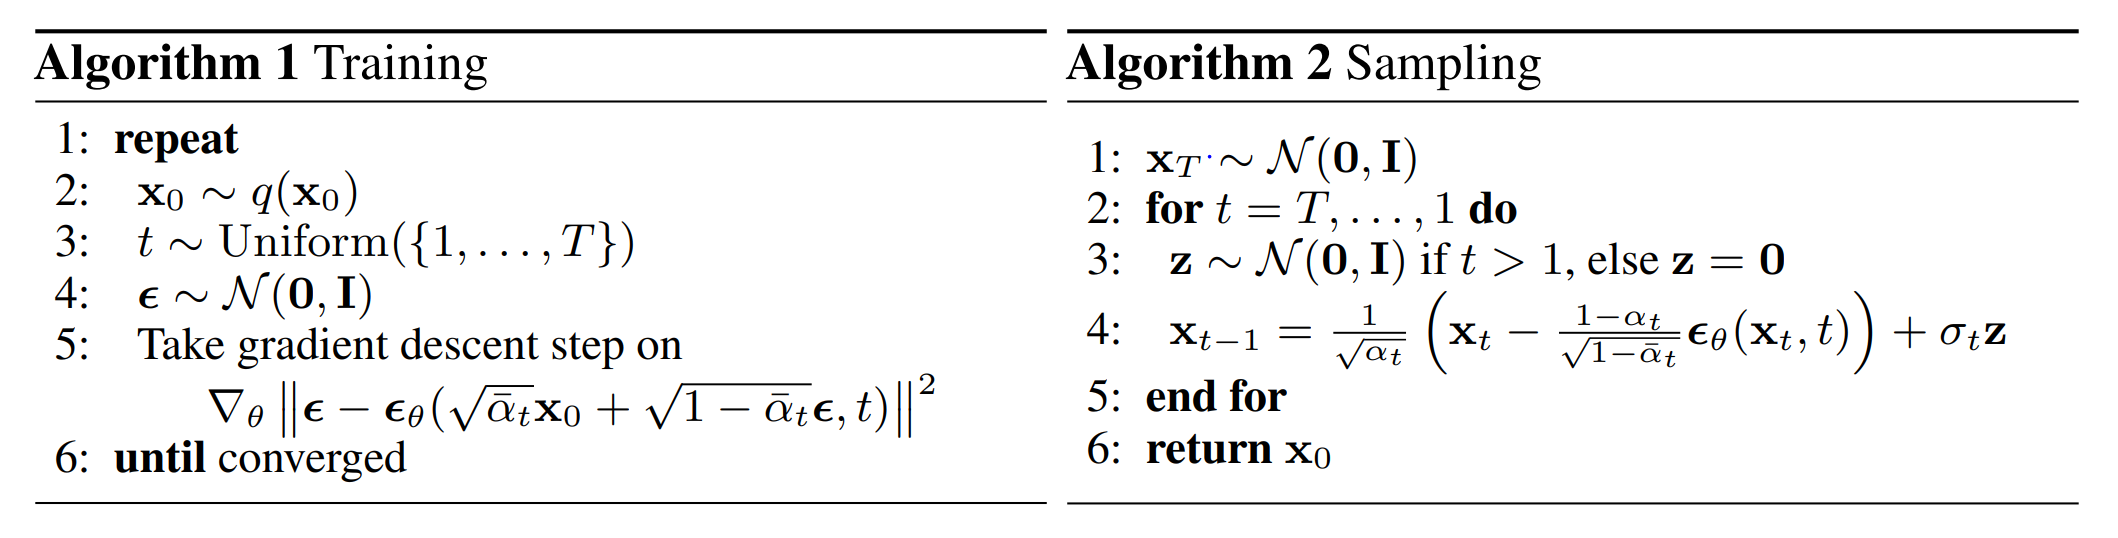

The pseudocode shows that the loss function is defined as an MSE on per time step noise and the predicted noise for the current time step. So we only need to train a model that learns to reverse the noise from an input image at a specific time step. In this notebook, we will use the architecture proposed by the paper, a UNet with image and time as the inputs and predicted noise as the output. They augment the regular UNet with several sub-modules and techniques such as ResNets, Attention modules, etc. We describe the expected architecture for this notebook:

+ *ResNet:* As a base sub-module, we define each ResNet block as two consecutive convolutional layers with a GELU activation in between and Group Normalization after each convolutional layer. You can use this module in Down/Up blocks. Also, by removing the residual connection, you can use this block as a convolutional network throughout the network.
+ *Attention:* This is also a sub-module consisting of a Layer Normalization, Multi-head Attention (use from `torch.nn`), a residual connection, a feed-forward network, and another residual connection.
+ *Conditional UNet:* Each Up/Down block in UNet accepts positionally-encoded time as an input. The time index is encoded and added to the output of the block. You can use the sinusoidal position embeddings proposed in [Attention is All You Need.](https://arxiv.org/pdf/1706.03762.pdf)

You can implement the following structure for UNet:

+ Convolutional block
+ Down block
+ Attention 
+ Down block
+ Attention
+ Down block
+ Attention

+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)

+ Up block
+ Attention
+ Up block
+ Attention
+ Up block
+ Attention
+ Convolutional block

In [ ]:
##########################################################
# TODO (40 points): 
# Complete each class based on the previous explanations.
##########################################################

class ConvResNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ConvResNet, self).__init__()

    def forward(self, x):
        pass

class Down(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Down, self).__init__()

    def forward(self, x, t):
        pass


class Up(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Up, self).__init__()

    def forward(self, x, skip, t):
        pass


class Attention(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Attention, self).__init__()

    def forward(self, x):
        pass


class UNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super(UNet, self).__init__()

    def forward(self, x, t):
        pass


In [ ]:
class DDPMManager():
    def __init__(self):

        self.T = 1000
        self.beta_start = 1e-4 # \beta_t is the sqrt(\sigma_t) from the pseudocode.
        self.beta_end = 0.02

        ##########################################################
        # TODO (6 points): 
        # Instantiate the model and the optimizer. You can use Adam.
        # Define \alpha, \beta, and \bar{alpha} for all T time steps. 
        # Use cosine scheduling for \beta.
        ##########################################################

        self.unet = None

    def train(self, dataloader, **kwargs):

        history = dict(loss=[])
        for epoch in range(EPOCHS):
            total_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)

                ##########################################################
                # TODO (15 points): 
                # Sample a time step `t` and create noisy images for the  
                # `t`th step of the diffusion according to \bar{alpha} 
                # values. Then predict the noise using self.unet.
                # Compute the loss and backpropagate.
                ##########################################################

                loss = None

                total_loss.append(loss.item())

            mean_loss = np.mean(total_loss)
            print(
                "[Epoch: %d/%d] [loss: %.4f]"
                % (epoch+1, EPOCHS, mean_loss)
            )

            self.sample(8, plot=True)

            history['loss'].append(mean_loss)

        return history
    
    def sample(self, n, plot=True):

        ##########################################################
        # TODO (8 points): 
        # Generate a random pattern `x`. 
        # Then denoise `x` for self.T time steps.
        # Choose `n` images from the generated images during self.T 
        # time steps (`xs`).
        # The purpose is to show how denoising converts the pure 
        # noise to an image after self.T time steps.
        ##########################################################

        with torch.no_grad():
            x = None
            xs = None
            if plot:
                plot_images(xs)
            return x

In [ ]:
ddpm = DDPMManager() # You can pass your arguments to the call.
ddpm_history = ddpm.train(dataloader)

### ❓ **Question 4**
> + *(4 points)* How can we generate images from a specific target class in DDPM?
+ *(Bonus - 25 points)* Implement your idea and plot one trajectory of denoised images per class.

## Comparisons (10 points)

History of each training has been stored in `[MODEL]_history`. Plot the losses for each model. Also sample images from each model and compare your results. 